## Yelp Challenge

Dataset Documentation: <br>
https://www.yelp.com/dataset/documentation/main

In [1]:
import pandas as pd
import numpy as np
from cmfrec import CMF
import pycmf

import time
from copy import deepcopy

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from surprise import SVD
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import GridSearchCV
from surprise import Dataset
from surprise import BaselineOnly

import matplotlib.pyplot as plt
import tarfile
import json
from tqdm import tqdm

In [2]:
# load business.json
# 192609 unique businesses?
line_count = len(open("./yelp_dataset/business.json").readlines())
business_ids, cities, states, latitudes, longitudes, stars, review_counts, attributes, categories = [], [], [], [], [], [], [], [], []
with open("./yelp_dataset/business.json") as f:
    for line in tqdm(f, total=line_count):
        blob = json.loads(line)
        business_ids += [blob["business_id"]]
        cities += [blob["city"]]
        states += [blob["state"]]
        latitudes += [blob["latitude"]]
        longitudes += [blob["longitude"]]
        stars += [blob["stars"]]
        review_counts += [blob["review_count"]]
        attributes += [blob["attributes"]]
        categories += [blob["categories"]]
        
businesses = pd.DataFrame(
    {"business_id": business_ids, "city": cities, "state": states, "latitude": latitudes, "longitude": longitudes, "stars": stars, "review_counts": review_counts, "attributes": attributes, "categories":categories }
)

100%|██████████| 192609/192609 [00:02<00:00, 66274.86it/s]


In [3]:
# load user.json
# 1637138 unique users?
line_count = len(open("./yelp_dataset/user.json").readlines())
users, review_counts, elites, average_stars, friends = [], [], [], [], []
with open("./yelp_dataset/user.json") as f:
    for line in tqdm(f, total=line_count):
        blob = json.loads(line)
        users += [blob["user_id"]]
        review_counts += [blob["review_count"]]
        elites += [blob["elite"]]
        average_stars += [blob["average_stars"]]
        friends += [blob["friends"]]
        
users = pd.DataFrame(
    {"user_id": users, "review_count": review_counts,"elite": elites, "average_stars": average_stars, "friends": friends}
)

100%|██████████| 1637138/1637138 [00:21<00:00, 76015.16it/s] 


In [4]:
# load review.json
# 6685900 unique reviews?
line_count = len(open("./yelp_dataset/review.json").readlines())
user_ids, business_ids, stars, dates, texts = [], [], [], [], []
with open("./yelp_dataset/review.json") as f:
    for line in tqdm(f, total=line_count):
        blob = json.loads(line)
        user_ids += [blob["user_id"]]
        business_ids += [blob["business_id"]]
        stars += [blob["stars"]]
        dates += [blob["date"]]
        texts += [blob["text"]]
reviews = pd.DataFrame(
    {"user_id": user_ids, "business_id": business_ids, "rating": stars, "date": dates, "text": texts}
)
user_counts = reviews["user_id"].value_counts()
active_users = user_counts.loc[user_counts >= 5].index.tolist()
reviews = reviews.loc[reviews.user_id.isin(active_users)]

100%|██████████| 6685900/6685900 [01:12<00:00, 92720.46it/s] 


In [5]:
def process(df):
    df = df.drop(df.columns[0], axis =1)
    df['date']  = pd.to_datetime(df['date'])
    df['week_day'] = df['date'].dt.weekday
    df['month'] = df['date'].dt.month
    df['hour'] = df['date'].dt.hour
    df = df.merge(users, on = 'user_id')
    df = df.merge(businesses, on = 'business_id')
    return df

## Loading Data: 20%, 50%, 100%


In [6]:
ratings_holdout_20 = pd.read_csv('data/ratings_sample_holdout_20.csv')
ratings_train_20 = pd.read_csv('data/ratings_sample_train_20.csv')
ratings_val_20 = pd.read_csv('data/ratings_sample_cv_20.csv')

ratings_holdout_50 = pd.read_csv('data/ratings_sample_holdout_50.csv')
ratings_val_50 = pd.read_csv('data/ratings_sample_cv_50.csv')
ratings_train_50 = pd.read_csv('data/ratings_sample_train_50.csv')

ratings_holdout_100 = pd.read_csv('data/ratings_sample_holdout_100.csv')
ratings_train_100 = pd.read_csv('data/ratings_sample_train_100.csv')
ratings_val_100 = pd.read_csv('data/ratings_sample_cv_100.csv')

/Users/bowenzhou/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
spars_20_df = ratings_train_20.loc[:,['user_id','business_id']]

In [27]:
spars_20_df.business_id.nunique()

121736

In [28]:
spars_20_df.user_id.nunique()

57223

In [37]:
121736*57223

6966099128

In [29]:
ratings_train_20.shape[0]

803897

In [39]:
# sparsity for 20%
spars_20 = 1- ratings_train_20.shape[0]/ (ratings_train_20.user_id.nunique()*ratings_train_20.business_id.nunique())

In [40]:
# sparsity for 50%
spars_50 = 1- ratings_train_50.shape[0]/ (ratings_train_50.user_id.nunique()*ratings_train_50.business_id.nunique())

In [41]:
# sparsity for 100%
spars_100 = 1- ratings_train_100.shape[0]/ (ratings_train_100.user_id.nunique()*ratings_train_100.business_id.nunique())

In [42]:
spars_20

0.99988459868497

In [43]:
spars_50

0.9999131874746705

In [44]:
spars_100

0.9999233903176662

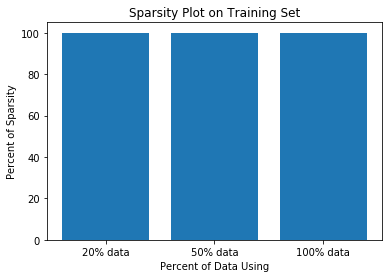

In [56]:
height = [spars_20*100, spars_50*100, spars_100*100]
bars = ('20% data', '50% data', '100% data')
y_pos = np.arange(len(bars))

plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Percent of Data Using")
plt.ylabel("Percent of Sparsity")
plt.title("Sparsity Plot on Training Set")
plt.show()